In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from src.datasets import load_train_test
from src.portfolio import Portfolio

import pandas as pd
import warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-03-02 20:28:03.482413: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 20:28:03.482469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 20:28:03.546311: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-02 20:28:03.660080: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-02 20:28:04.731292: W tensorflow/compiler/tf2

In [2]:

def train(X_train, y_train, num_epochs, batch_size, learning_rate):
    model = Sequential()
    model.add(LSTM(units=X_train.shape[2]*4, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(units=y_train.shape[1]))  # output for optimal weights for next week.

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    return model

tickers = ['V', 'GOOGL', 'T', 'JNJ', 'DIS']
start = '2013-01-01'
end = '2023-12-31'
num_epochs=512
batch_size=32
learning_rate=0.001

yfdata, features, targets, X, y, y_price = load_train_test(tickers, start, end)

print('========= Original Dataset =========')
print('features', features.shape, 'columns', features.index[0], features.index[-1])
print('targets', targets.shape, 'columns', targets.index[0], targets.index[-1])
print('X', X.shape)
print('y', y.shape)
print('y_price', y_price.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print('========= Train / Test Dataset =========')
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_price', y_price.shape)


[*********************100%%**********************]  5 of 5 completed


---- Creating Training Set
(2735, 108)
(2735, 6)
(2735, 6)
========= Original Dataset =========
features (2735, 108) columns 2013-02-20 00:00:00 2023-12-29 00:00:00
targets (2735, 6) columns 2013-02-20 00:00:00 2023-12-29 00:00:00
X (545, 10, 108)
y (545, 6)
y_price (545, 6)
========= Train / Test Dataset =========
X_train (436, 10, 108)
X_test (109, 10, 108)
y_train (436, 6)
y_test (109, 6)
y_price (545, 6)


In [3]:

model = train(X_train, y_train, num_epochs, batch_size, learning_rate)

2024-03-02 20:28:08.594564: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 20:28:08.781410: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 20:28:08.781981: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 20:28:08.785691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-02 20:28:08.786200: I external/local_xla/xla/stream_executor

Epoch 1/512


2024-03-02 20:28:11.181520: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-02 20:28:14.646754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1738 - loss: 0.3952 - val_accuracy: 0.1364 - val_loss: 0.2444
Epoch 2/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1567 - loss: 0.1579 - val_accuracy: 0.1705 - val_loss: 0.2035
Epoch 3/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1638 - loss: 0.1411 - val_accuracy: 0.1932 - val_loss: 0.1483
Epoch 4/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1665 - loss: 0.1074 - val_accuracy: 0.2273 - val_loss: 0.1355
Epoch 5/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1602 - loss: 0.1140 - val_accuracy: 0.1818 - val_loss: 0.1286
Epoch 6/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1612 - loss: 0.1031 - val_accuracy: 0.2159 - val_loss: 0.1262
Epoch 7/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1768 - loss: 0.1022 - val_accuracy: 0.2045 - val_loss: 0.1174
Epoch 8/512
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1655 - loss: 0.0895 - val_accuracy: 0.2386 - val_l

In [4]:

optimal_portfolio = Portfolio.portfolio_returns('optimal', y_test, y_price[-1*len(y_test):])
model_portfolio = Portfolio.portfolio_returns('model', model.predict(X_test), y_price[-1*len(y_test):])

overall = optimal_portfolio.join(model_portfolio)

print(overall)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
            optimal_returns  optimal_cumrets  model_returns  model_cumrets
2021-11-05         0.009535         1.009535      -0.041921       0.958079
2021-11-12         0.001555         1.011105      -0.044744       0.915211
2021-11-19         0.000137         1.011243       0.004864       0.919662
2021-11-29         0.025129         1.036655      -0.001995       0.917827
2021-12-06         0.035510         1.073466       0.033811       0.948860
...                     ...              ...            ...            ...
2023-11-27         0.041554        26.036398      -0.028638       0.707096
2023-12-04         0.033130        26.898993       0.015903       0.718340
2023-12-08         0.007253        27.094090       0.005902       0.722580
2023-12-15         0.062145        28.777859       0.002231       0.724192
2023-12-22         0.000000        28.777859       0.000000       0.724192

[109 rows x 4 columns]


<Axes: >

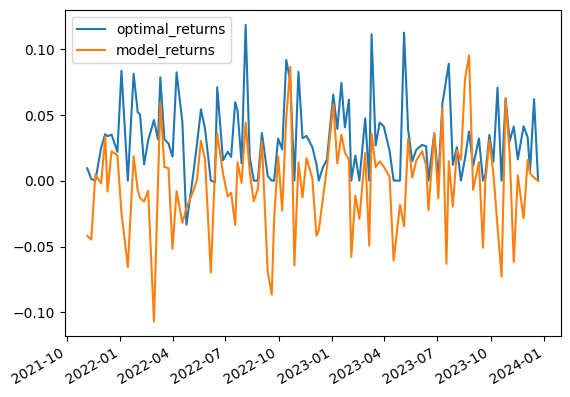

In [5]:
overall[['optimal_returns', 'model_returns']].plot()

<Axes: >

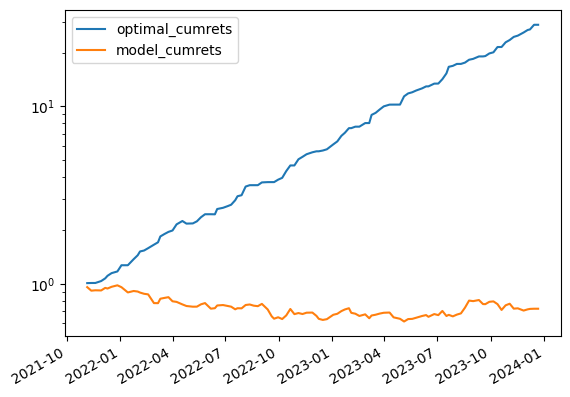

In [6]:
overall[['optimal_cumrets', 'model_cumrets']].plot(logy=True)